In [81]:
#Imports & Device Setup

import os
import pandas as pd
import numpy as np
import random
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.utils import make_grid

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score

In [13]:
#Keep only the rows where the image file actually exists

def filter_csv_by_existing_files(csv_path, base_data_dir, output_path):
    df = pd.read_csv(csv_path)
    def file_exists(rel_path):
        full_path = os.path.join(base_data_dir, rel_path.strip())
        return os.path.isfile(full_path)
        
    filtered_df = df[df['Path'].apply(file_exists)]
    
    print(f"Filtered {csv_path}:")
    print(f"  Original rows: {len(df)}")
    print(f"  Rows with existing files: {len(filtered_df)}")
    
    filtered_df.to_csv(output_path, index=False)

base_dir = '/Users/apple/Desktop/SignSpotter/data'  
train_csv = os.path.join(base_dir, 'Train.csv')
test_csv = os.path.join(base_dir, 'Test.csv')

filter_csv_by_existing_files(train_csv, base_dir, os.path.join(base_dir, 'Train_filtered.csv'))
filter_csv_by_existing_files(test_csv, base_dir, os.path.join(base_dir, 'Test_filtered.csv'))

Filtered /Users/apple/Desktop/SignSpotter/data/Train.csv:
  Original rows: 39209
  Rows with existing files: 39209
Filtered /Users/apple/Desktop/SignSpotter/data/Test.csv:
  Original rows: 12630
  Rows with existing files: 12630


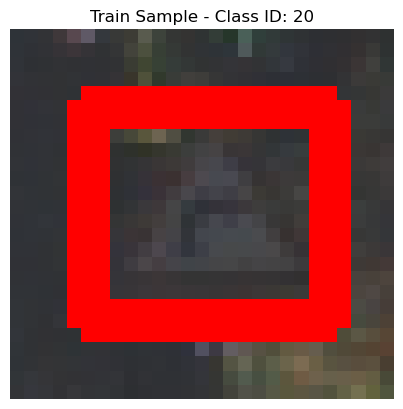

In [15]:
#Visualize a sample image with the bounding box (ROI) and class label

def show_sample(df, dataset_type = 'Train', index=0):
    row = df.iloc[index]
    img_path = os.path.join(dataset_dir, row['Path'])

    img = cv2.imread(img_path)
    if img is None:
        print(f"[!] Image not found or cannot be read: {img_path}")
        return
        
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    #Rectangular box indicating the Region of Interest
    x1, y1, x2, y2 = int(row['Roi.X1']), int(row['Roi.Y1']), int(row['Roi.X2']), int(row['Roi.Y2'])
    class_id = row['ClassId']
    cv2.rectangle(img, (x1,y1), (x2,y2), color=(255, 0, 0), thickness = 2)
    
    plt.imshow(img)
    plt.title(f"{dataset_type} Sample - Class ID: {class_id}")
    plt.axis('off')
    plt.show()


dataset_dir = '/Users/apple/Desktop/SignSpotter/data'
filtered_train_df = pd.read_csv(os.path.join(dataset_dir, 'Train_filtered.csv'))

#Show sample image from Train set
for i in range(1):
    show_sample(filtered_train_df, dataset_type = 'Train', index=i)                                                              

In [17]:
#Structured data loading

class TrafficSignDataset(Dataset):
    def __init__(self, csv_file, data_dir, transform=None, use_roi=False):
        self.data = pd.read_csv(csv_file)
        self.data_dir = data_dir
        self.transform = transform
        self.use_roi = use_roi

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = os.path.join(self.data_dir, row['Path'])
        image = Image.open(img_path).convert("RGB")  

        if self.use_roi:
            x1, y1, x2, y2 = row['Roi.X1'], row['Roi.Y1'], row['Roi.X2'], row['Roi.Y2']
            image = image.crop((x1, y1, x2, y2))

        if self.transform:
            image = self.transform(image)

        label = row['ClassId']
        return image, label

In [19]:
#Image preprocessing transformations (Data augmentation + normalization for RGB images)
transform = transforms.Compose([
    transforms.Resize((64, 64)),                          
    transforms.RandomRotation(15),                        # rotate signs slightly
    transforms.RandomAffine(0, translate=(0.1, 0.1)),     # shift signs around the frame
    transforms.ColorJitter(brightness=0.3, contrast=0.3), # realistic lighting variation
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), 
                         (0.5, 0.5, 0.5))                 #normalization for RGB
])


In [21]:
csv_file = '/Users/apple/Desktop/SignSpotter/data/Train_filtered.csv'
data_dir = '/Users/apple/Desktop/SignSpotter/data'

# Create dataset
train_dataset = TrafficSignDataset(csv_file=csv_file, data_dir=data_dir, transform=transform, use_roi=True)

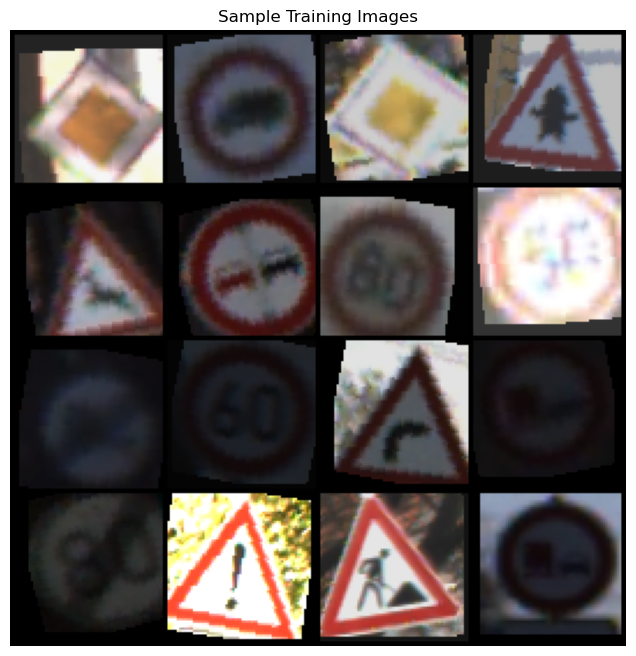

In [23]:
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle = True)

images, labels = next(iter(train_loader))
images = images * 0.5 + 0.5 
grid = make_grid(images, nrow = 4)

plt.figure(figsize = (8,8))
plt.imshow(grid.permute(1,2,0))
plt.title("Sample Training Images")
plt.axis('off')
plt.show()

In [25]:
#Device setup

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)

Using device: mps


In [27]:
#MobileNetV2 Model Definition

from torchvision import models

class TrafficSignMobileNet(nn.Module):
    def __init__(self, num_classes=43):
        super().__init__()
        # Load pretrained MobileNetV2
        self.model = models.mobilenet_v2(weights='IMAGENET1K_V1')

        in_features = self.model.classifier[1].in_features
        self.model.classifier[1] = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.model(x)


In [29]:
#Initialising the Model
num_epochs = 5
learning_rate = 0.001

model = TrafficSignMobileNet(num_classes=43).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

print("Model device:", next(model.parameters()).device)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /Users/apple/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████████████████████████████████| 13.6M/13.6M [00:02<00:00, 4.87MB/s]


Model device: mps:0


In [31]:
from sklearn.model_selection import train_test_split

csv_file = '/Users/apple/Desktop/SignSpotter/data/Train_filtered.csv'
data_dir = '/Users/apple/Desktop/SignSpotter/data'

df = pd.read_csv(csv_file)

train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['ClassId'], random_state=42)

train_df.to_csv(os.path.join(data_dir, 'Train_split.csv'), index=False)
val_df.to_csv(os.path.join(data_dir, 'Val_split.csv'), index=False)

In [33]:
#Batches for training and evaluation.

train_dataset = TrafficSignDataset(
    csv_file = os.path.join(data_dir, 'Train_split.csv'),
    data_dir = data_dir,
    transform = transform,
    use_roi = True
)

val_dataset = TrafficSignDataset(
    csv_file = os.path.join(data_dir, 'Val_split.csv'),
    data_dir = data_dir,
    transform = transform,
    use_roi = True
)

test_csv = os.path.join(data_dir, "Test.csv")
test_dataset = TrafficSignDataset(
    csv_file=test_csv,
    data_dir=data_dir,
    transform=transform,
    use_roi=True
)


train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = 64, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [35]:
#Track model performance per batch

def calculate_accuracy(outputs,labels):
    _, preds = torch.max(outputs, 1)
    correct = (preds == labels).sum().item()
    return correct / labels.size(0)

In [37]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=5):
    best_acc = 0.0

    # Lists to store metrics
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss, running_corrects, total = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += (preds == labels).sum().item()
            total += labels.size(0)

        epoch_loss = running_loss / total
        epoch_acc = running_corrects / total

        # Store metrics
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        # VALIDATION
        model.eval()
        val_loss, val_corrects, val_total = 0.0, 0, 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                val_corrects += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_loss /= val_total
        val_acc = val_corrects / val_total

        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        # Save best model
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "best_signspotter_model.pth")

        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f} "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    # Return all recorded metrics
    return train_losses, val_losses, train_accuracies, val_accuracies


In [39]:
train_losses, val_losses, train_accs, val_accs = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=10 
)

Epoch [1/10] Train Loss: 0.3658 | Train Acc: 0.8897 Val Loss: 0.1165 | Val Acc: 0.9661
Epoch [2/10] Train Loss: 0.0898 | Train Acc: 0.9740 Val Loss: 0.0725 | Val Acc: 0.9786
Epoch [3/10] Train Loss: 0.0720 | Train Acc: 0.9799 Val Loss: 0.0398 | Val Acc: 0.9884
Epoch [4/10] Train Loss: 0.0501 | Train Acc: 0.9855 Val Loss: 0.0998 | Val Acc: 0.9727
Epoch [5/10] Train Loss: 0.0810 | Train Acc: 0.9790 Val Loss: 0.0167 | Val Acc: 0.9949
Epoch [6/10] Train Loss: 0.0375 | Train Acc: 0.9893 Val Loss: 0.0583 | Val Acc: 0.9833
Epoch [7/10] Train Loss: 0.0415 | Train Acc: 0.9882 Val Loss: 0.0604 | Val Acc: 0.9821
Epoch [8/10] Train Loss: 0.0446 | Train Acc: 0.9873 Val Loss: 0.0132 | Val Acc: 0.9962
Epoch [9/10] Train Loss: 0.0272 | Train Acc: 0.9919 Val Loss: 0.0143 | Val Acc: 0.9963
Epoch [10/10] Train Loss: 0.0380 | Train Acc: 0.9890 Val Loss: 0.0200 | Val Acc: 0.9938


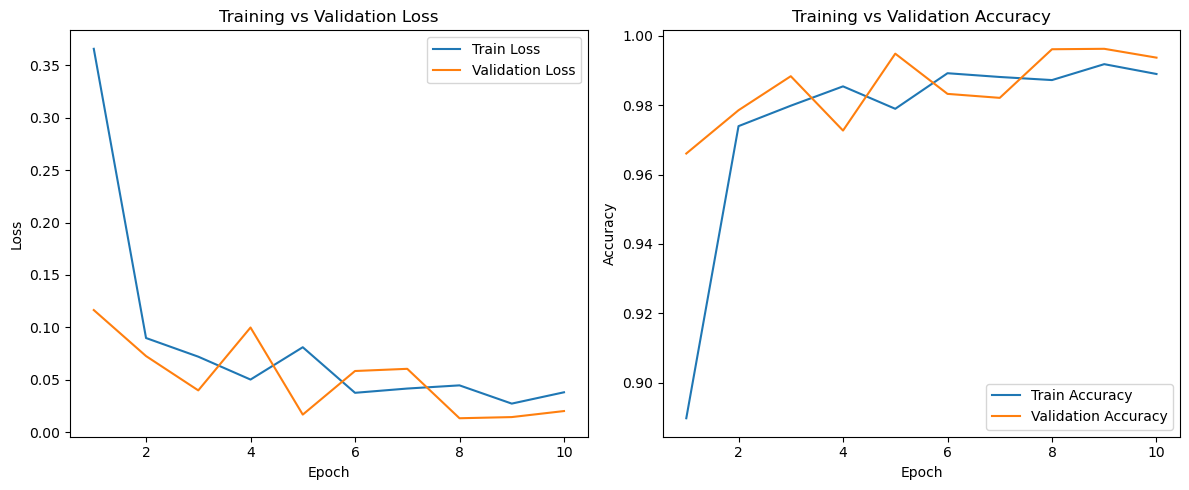

In [41]:
#Plotting  Training & Validation Curves

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12,5))

# Loss plot
plt.subplot(1,2,1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

# Accuracy plot
plt.subplot(1,2,2)
plt.plot(epochs, train_accs, label='Train Accuracy')
plt.plot(epochs, val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [53]:
#Load Best Saved Model for Evaluation
best_model = TrafficSignMobileNet(num_classes=43).to(device)
best_model.load_state_dict(torch.load("best_signspotter_model.pth", map_location=device))
best_model.eval()

print("Best model loaded successfully.")

Best model loaded successfully.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

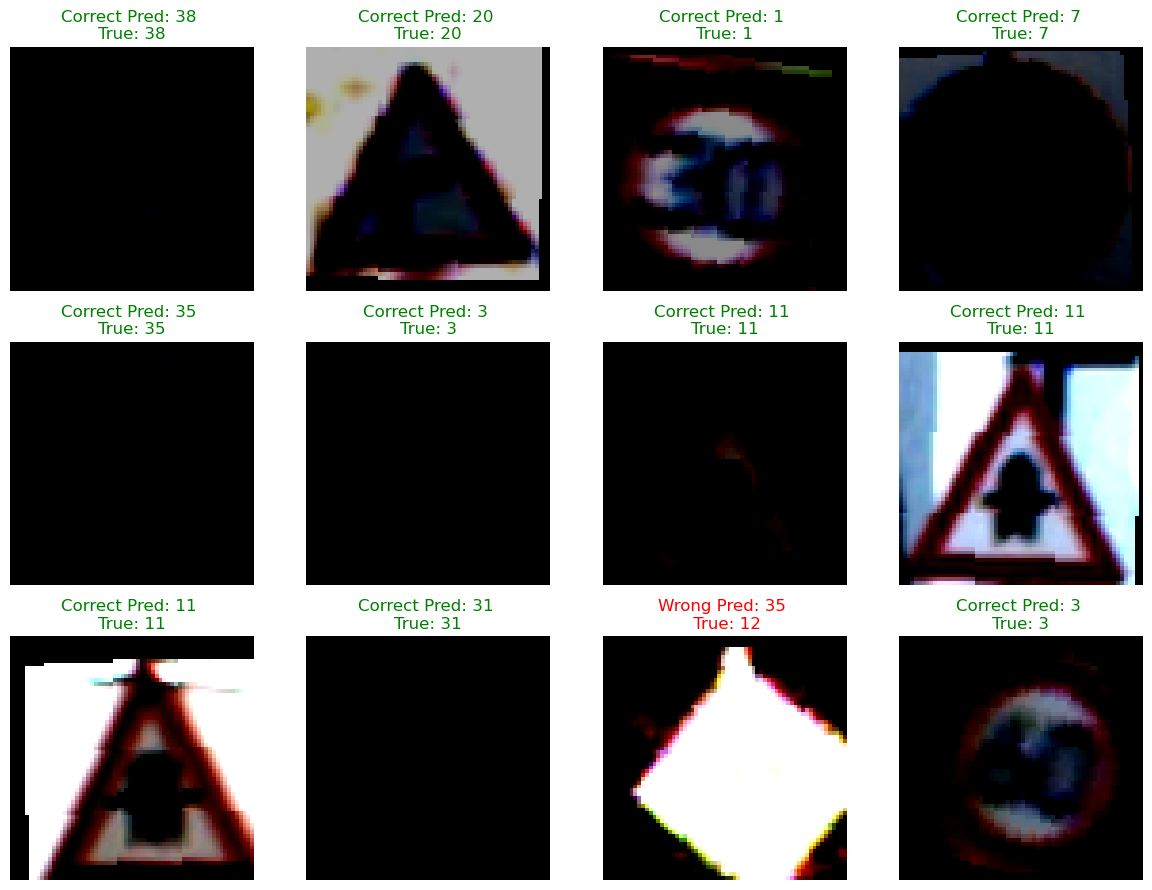

Model saved to signspotter_mobilenet.pth


In [59]:
#Visualizing random test samples
best_model.eval()

num_samples = 12
indices = random.sample(range(len(test_dataset)), num_samples)

best_model.eval()
fig, axes = plt.subplots(3,4, figsize = (12, 9))
axes = axes.flatten()

#Prediction and plotting loop

for i, idx in enumerate(indices):
    image, true_label = test_dataset[idx]
    image_input = image.unsqueeze(0).to(device)
    with torch.no_grad():
        output = best_model(image_input)
        pred_label = output.argmax(1).item()

    img = image.permute(1,2,0).cpu().numpy()
    axes[i].imshow(img)
    axes[i].axis("off")
    if pred_label == true_label:
        axes[i].set_title(f"Correct Pred: {pred_label} \nTrue: {true_label}", color = "green")
    else:
        axes[i].set_title(f"Wrong Pred: {pred_label} \n True: {true_label}", color = "red")
plt.tight_layout()
plt.show()

#Saving the model

MODEL_PATH = "signspotter_mobilenet.pth"
torch.save(best_model.state_dict(), MODEL_PATH)
print(f"Model saved to {MODEL_PATH}")

In [61]:
#RELOAD THE MODEL
loaded_model = TrafficSignMobileNet(num_classes=43).to(device)
loaded_model.load_state_dict(torch.load(MODEL_PATH))
loaded_model.eval()

print(f"Model loaded and ready for inference")

Model loaded and ready for inference


In [63]:
#Map numeric class IDs (0–42) to human-readable traffic sign names

class_id_to_name = {
    0: "Speed limit (20km/h)",
    1: "Speed limit (30km/h)",
    2: "Speed limit (50km/h)",
    3: "Speed limit (60km/h)",
    4: "Speed limit (70km/h)",
    5: "Speed limit (80km/h)",
    6: "End of speed limit (80km/h)",
    7: "Speed limit (100km/h)",
    8: "Speed limit (120km/h)",
    9: "No passing",
    10: "No passing for vehicles over 3.5 tons",
    11: "Right-of-way at intersection",
    12: "Priority road",
    13: "Yield",
    14: "Stop",
    15: "No vehicles",
    16: "Vehicles over 3.5 tons prohibited",
    17: "No entry",
    18: "General caution",
    19: "Dangerous curve left",
    20: "Dangerous curve right",
    21: "Double curve",
    22: "Bumpy road",
    23: "Slippery road",
    24: "Road narrows on the right",
    25: "Road work",
    26: "Traffic signals",
    27: "Pedestrians",
    28: "Children crossing",
    29: "Bicycles crossing",
    30: "Beware of ice/snow",
    31: "Wild animals crossing",
    32: "End of all speed and passing limits",
    33: "Turn right ahead",
    34: "Turn left ahead",
    35: "Ahead only",
    36: "Go straight or right",
    37: "Go straight or left",
    38: "Keep right",
    39: "Keep left",
    40: "Roundabout mandatory",
    41: "End of no passing",
    42: "End of no passing for vehicles over 3.5 tons"
}

In [65]:
#Predict and visualize a single image

test_csv_path = "/Users/apple/Desktop/SignSpotter/data/Test.csv" 
df_test = pd.read_csv(test_csv_path)

def predict_image(image_path, model, transform, device=None, df=None, data_dir="/Users/apple/Desktop/SignSpotter/data"):

    #Device and model setup
    if device is None:
        device = "mps" if torch.backends.mps.is_available() else "cpu"
    
    model = model.to(device)
    model.eval()

    image = Image.open(image_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)
    
    # Get prediction
    with torch.no_grad():
        outputs = model(input_tensor)
        _, preds = torch.max(outputs, 1)
    
    predicted_class = preds.item()
    predicted_name = class_id_to_name[predicted_class]

    # Lookup true label from CSV if available
    true_label, true_name = None, None
    if df is not None:
        rel_path = os.path.relpath(image_path, data_dir).replace("\\", "/")
        row = df[df["Path"].str.replace("\\", "/") == rel_path]
        if not row.empty:
            true_label = int(row["ClassId"].values[0])
            true_name = class_id_to_name[true_label]

    #Display the image with prediction
    plt.imshow(image)
    title = f"Predicted: {predicted_name}"
    if true_name is not None:
        title += f"\nTrue: {true_name}"
    plt.title(title, fontsize=12, color="green" if predicted_class == true_label else "red")
    plt.axis("off")
    plt.show()

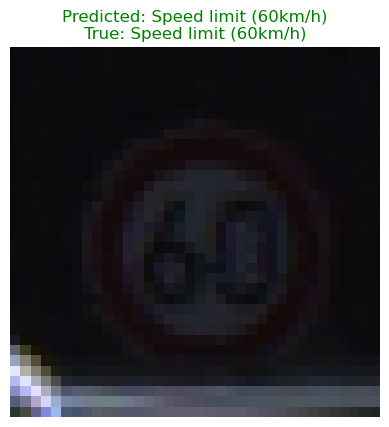

In [67]:
img_path = "/Users/apple/Desktop/SignSpotter/data/Test/00090.png"

predict_image(
    img_path,
    model,
    transform,
    device="cpu",
    df=df_test,
    data_dir="/Users/apple/Desktop/SignSpotter/data"
)

In [69]:
#Evaluate Full Test Set

def evaluate_model(model, transform, df, data_dir, device="cpu"):
    correct = 0
    total = len(df)
    
    model = model.to(device)
    model.eval()
    
    for i in range(total):
        img_path = os.path.join(data_dir, df.loc[i, "Path"])
        true_label = int(df.loc[i, "ClassId"])
        
        # Load and preprocess image
        image = Image.open(img_path).convert("RGB")
        input_tensor = transform(image).unsqueeze(0).to(device)
        
        # Predict
        with torch.no_grad():
            outputs = model(input_tensor)
            _, preds = torch.max(outputs, 1)
        
        pred_class = preds.item()
        
        if pred_class == true_label:
            correct += 1
    
    accuracy = 100 * correct / total
    print(f" Test Accuracy: {accuracy:.2f}% ({correct}/{total})")
    return accuracy

In [71]:
evaluate_model(model, transform, df_test, "/Users/apple/Desktop/SignSpotter/data", device="cpu")

 Test Accuracy: 83.26% (10516/12630)


83.26207442596991

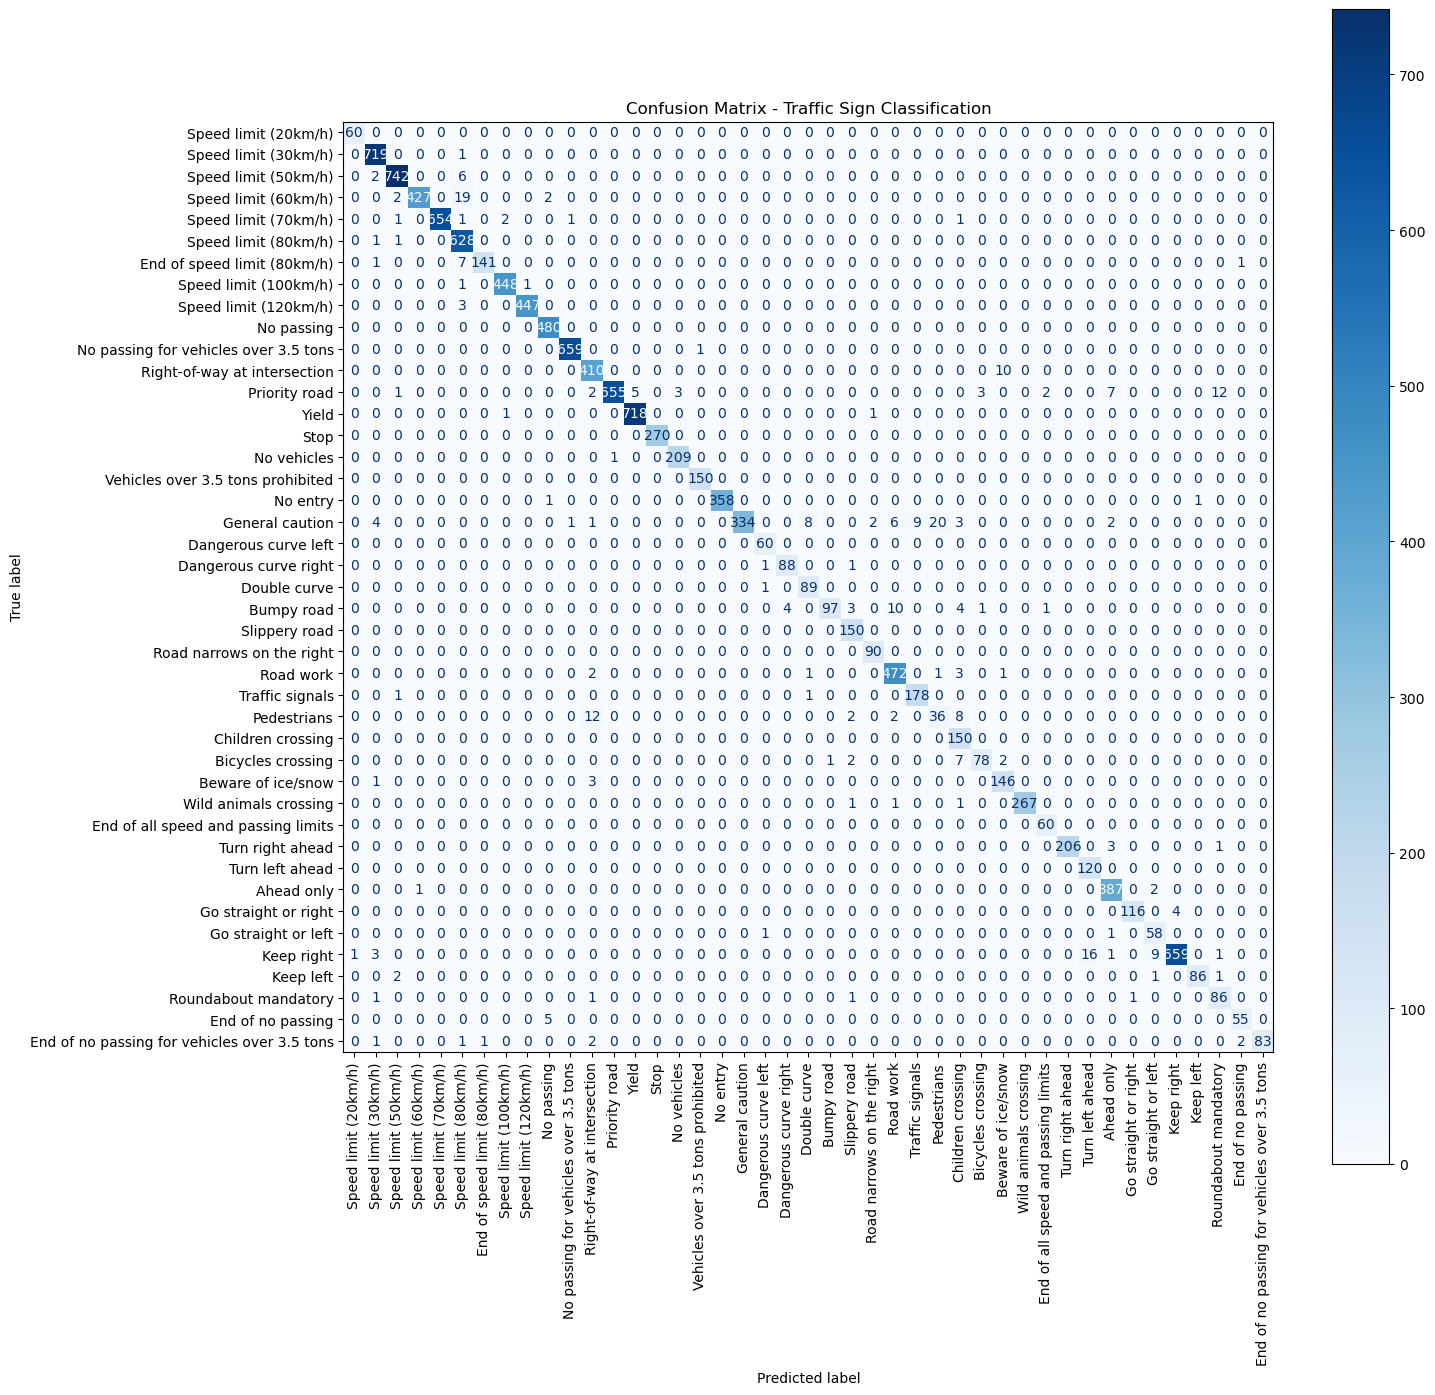

In [73]:
# Put model in eval mode
model.eval()

# Get all predictions and true labels
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to("cpu"), labels.to("cpu")
        model = model.to("cpu")
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot it with labels
fig, ax = plt.subplots(figsize=(15, 15))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[class_id_to_name[i] for i in range(len(class_id_to_name))])
disp.plot(ax=ax, cmap="Blues", xticks_rotation=90, values_format="d")
plt.title("Confusion Matrix - Traffic Sign Classification")
plt.show()


In [75]:
#Visualize a grid of random test predictions

#unnormalize for plotting
def imshow(img, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]):
    img = img.numpy().transpose((1, 2, 0))  # CHW -> HWC
    img = std * img + mean  # reverse normalization
    img = np.clip(img, 0, 1)  # keep in [0,1] range
    plt.imshow(img)

def show_predictions_grid(model, test_loader, class_id_to_name, device="cpu", num_images=9):
    model.eval()
    model.to(device)

    images, labels = next(iter(test_loader))
    idxs = random.sample(range(len(images)), num_images)

    plt.figure(figsize=(12, 12))
    for i, idx in enumerate(idxs):
        img = images[idx].unsqueeze(0).to(device)
        true_label = labels[idx].item()

        with torch.no_grad():
            outputs = model(img)
            _, pred = torch.max(outputs, 1)
            predicted_class = pred.item()

        predicted_name = class_id_to_name[predicted_class]
        true_name = class_id_to_name[true_label]

        plt.subplot(int(num_images**0.5), int(num_images**0.5), i+1)
        imshow(images[idx])  # <- FIXED here
        plt.axis("off")

        color = "green" if predicted_class == true_label else "red"
        plt.title(f"Pred: {predicted_name}\nTrue: {true_name}", color=color, fontsize=10)

    plt.tight_layout()
    plt.show()

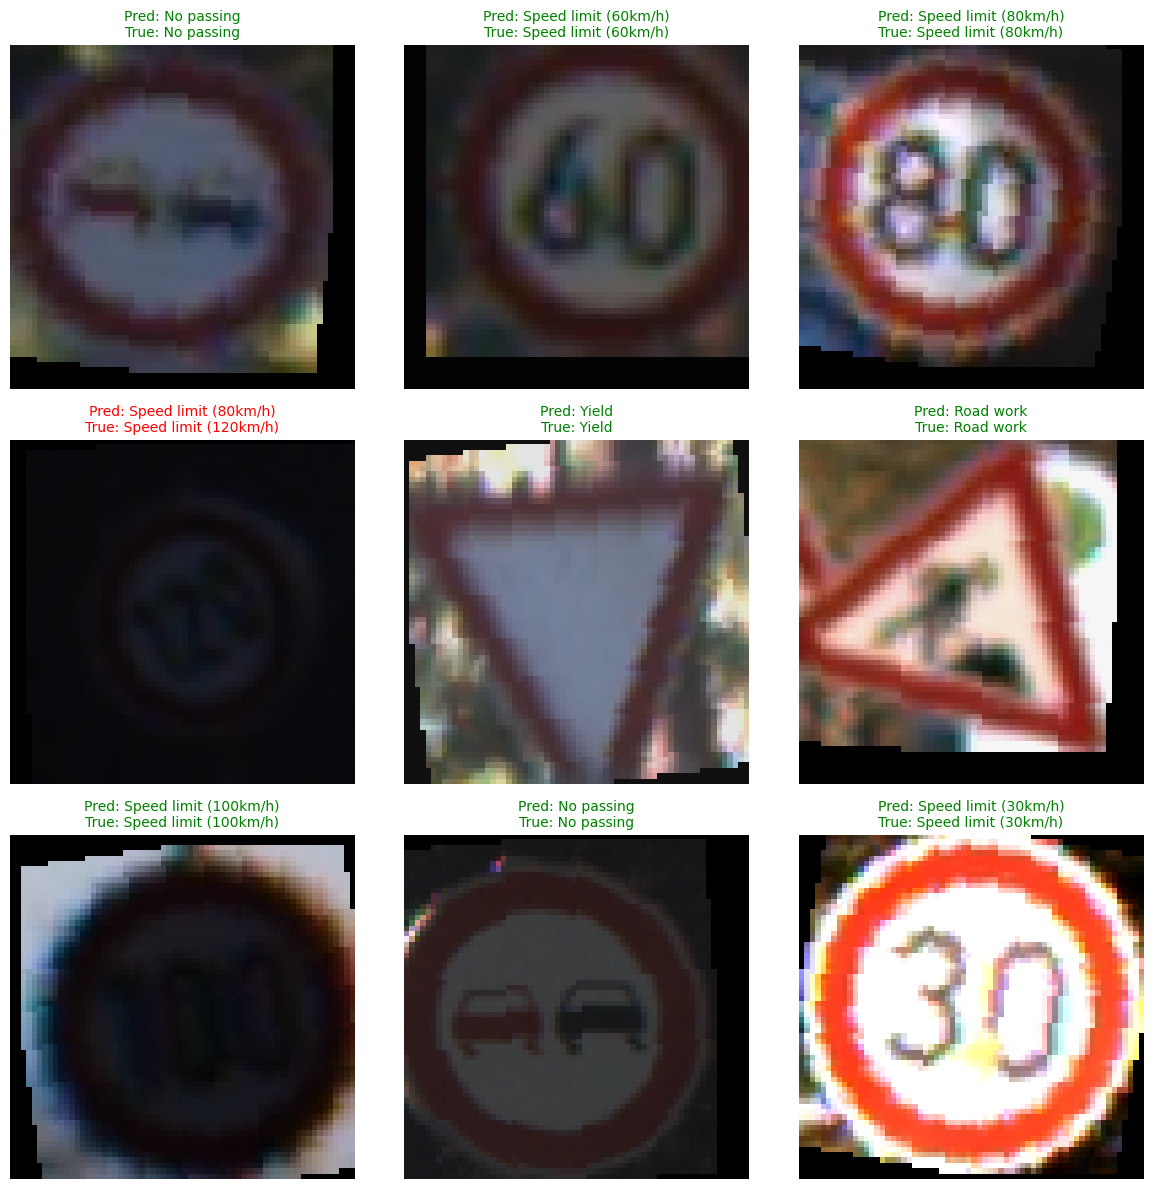

In [77]:
show_predictions_grid(model, test_loader, class_id_to_name, device="cpu", num_images=9)